# Project 3 : Hypothethis Testing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import scipy.stats as stats

import statsmodels.multivariate.manova as manova
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sqlalchemy import create_engine

#configs
%matplotlib inline
sns.set_style('whitegrid')

#paths
data_path = './data'
image_path = './images/'

In [2]:
#Connect to pitchfork database dump
conn = create_engine(f'sqlite:///{data_path}/database.sqlite').connect()

In [3]:
db_tbls_df = pd.read_sql("select * from sqlite_master",conn)

In [4]:
db_tables = {tbl_name : pd.read_sql(f'SELECT * FROM {tbl_name}',conn)
             for tbl_name
             in db_tbls_df['tbl_name']
            }

In [5]:
for key in db_tables.keys():
    print (f"{key}: {list(db_tables[key].columns)}")

reviews: ['reviewid', 'title', 'artist', 'url', 'score', 'best_new_music', 'author', 'author_type', 'pub_date', 'pub_weekday', 'pub_day', 'pub_month', 'pub_year']
artists: ['reviewid', 'artist']
genres: ['reviewid', 'genre']
labels: ['reviewid', 'label']
years: ['reviewid', 'year']
content: ['reviewid', 'content']


## Pitchfork Dataset

### Check for albums reviewed more than once

In [6]:
pd.read_sql("""
SELECT COUNT(reviewid) as cnt, avg(score), * 
FROM (SELECT * 
        FROM reviews 
        WHERE pub_year <2013) 
GROUP BY (title)
HAVING cnt > 1
ORDER BY cnt DESC
LIMIT 5""",
conn)

,cnt,avg(score),reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,14,7.342857,17223,dj-kicks,hercules and love affair,http://pitchfork.com/reviews/albums/17223-dj-k...,7.0,0,tim finney,None,2012-10-22,0,22,10,2012
1,9,7.366667,16962,ii,nude beach,http://pitchfork.com/reviews/albums/16962-ii/,7.4,0,steven hyden,contributor,2012-08-09,3,9,8,2012
2,7,7.057143,13658,greatest hits,foo fighters,http://pitchfork.com/reviews/albums/13658-grea...,7.0,0,matthew perpetua,None,2009-11-03,1,3,11,2009
3,7,5.442857,16618,live,me,http://pitchfork.com/reviews/albums/16618-live/,7.3,0,tim finney,None,2012-05-16,2,16,5,2012
4,6,7.616667,10250,dj kicks,hot chip,http://pitchfork.com/reviews/albums/10250-dj-k...,8.0,0,mark pytlik,contributor,2007-05-23,2,23,5,2007


* Albums that have been reviewed more then once will get a avarage score over all thier reviews
* Data on Albums labeled as genre global or experimental will be excluded, becuase they dont have a counterpart in the young peoples Dataset

In [7]:
pf_df = pd.read_sql("""
SELECT *
FROM 
    (SELECT avg(score) as album_score, * 
     FROM reviews
     WHERE pub_year <2013 
     GROUP BY (title))
JOIN genres 
USING(reviewid)
WHERE genre 
NOT IN('global','experimental')
""",conn)
pf_df.head()

,album_score,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre
0,7.5,17477,finally rich,chief keef,http://pitchfork.com/reviews/albums/17477-fina...,7.5,0,jayson greene,senior editor,2012-12-14,4,14,12,2012,rap
1,7.5,17487,tuna melt ep,a-trak,http://pitchfork.com/reviews/albums/17487-tuna...,7.5,0,miles raymer,contributor,2012-12-14,4,14,12,2012,rap
2,7.5,17487,tuna melt ep,a-trak,http://pitchfork.com/reviews/albums/17487-tuna...,7.5,0,miles raymer,contributor,2012-12-14,4,14,12,2012,electronic
3,8.0,17471,orbits,starkey,http://pitchfork.com/reviews/albums/17471-orbits/,8.0,0,nate patrin,contributor,2012-12-14,4,14,12,2012,electronic
4,4.8,17391,o.n.i.f.c.,wiz khalifa,http://pitchfork.com/reviews/albums/17391-onifc/,4.8,0,jordan sargent,None,2012-12-13,3,13,12,2012,rap


### Collect Data on avarage score by genre

In [8]:
#check whether album scoring has values between 0 and 10
pf_df['album_score'].describe()

count    13868.000000
mean         6.906780
std          1.390099
min          0.000000
25%          6.287500
50%          7.200000
75%          7.800000
max         10.000000
Name: album_score, dtype: float64

In [9]:
#transform album_score from (0-10) to the young people score (1-5) for comparison
scaler = MinMaxScaler(feature_range = (1,5),
                      copy = True)
scaler.fit(np.asarray(pf_df['album_score']).reshape(-1, 1))
pf_df['album_score'] = scaler.transform(pf_df[['album_score']])

In [10]:
#aggregate on genres
agg_metrics = ['mean','count']
pf_agg = (pf_df.groupby('genre')
          .agg({'album_score':agg_metrics})
          .sort_values(('album_score','mean'), ascending = True)
         )
pf_agg.columns = agg_metrics
pf_agg

,mean,count
genre,,
pop/r&b,3.727555,988
metal,3.732195,621
rap,3.743891,987
electronic,3.751600,2921
rock,3.763719,7481
folk/country,3.865215,519
jazz,3.888034,351


In [11]:
# add rank
pf_agg['rank'] = np.asarray(range(len(pf_agg))) + 1
pf_agg

,mean,count,rank
genre,,,
pop/r&b,3.727555,988,1
metal,3.732195,621,2
rap,3.743891,987,3
electronic,3.751600,2921,4
rock,3.763719,7481,5
folk/country,3.865215,519,6
jazz,3.888034,351,7


## Young Peoples Study

In [12]:
# young peoples study
yp_df = pd.read_csv(f"{data_path}/responses.csv")
yp_description = pd.read_csv(f"{data_path}/columns.csv")

## Cleaning

In [13]:
# Nan Values
yp_df.isna().sum().sum()

608

In [14]:
#Replace Nan with Median for Numerical Data and Mode for Nonnumerical Data
str_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')
str_cols = yp_df.select_dtypes(exclude = 'number').columns
num_cols = yp_df.select_dtypes(include = 'number').columns

In [15]:
df = pd.concat(
    [pd.DataFrame(str_imputer.fit_transform(yp_df[str_cols]), columns=str_cols),
     pd.DataFrame(num_imputer.fit_transform(yp_df[num_cols]), columns=num_cols)],
    axis=1
)

In [16]:
#Check for Success
yp_df = df
yp_df.isna().sum().sum()

0

In [17]:
#export
yp_df.to_csv(f"{data_path}/yp_df.csv")

# Hypothesis #1 Music Preferences in YP vs. Pitchfork

### Hypothethis declaration
+ H0: Music Preferences Ranks between the YP-Dataset and Pitchfork do not differ.
+ H1: Music Preferences Rnaks between the YP-Dataset and Pitchfork differ.

Hypothethis will be tested using Mann-Whitney test for rank comparison

### Avarage score by Genre

#### Preperating the Young Peoples Dataset

In [18]:
#Combine Folk and Country Column to match the Pitchfork Music Genres
yp_df["Folk, Country"] = (yp_df["Folk"]+yp_df["Country"])/2

In [19]:
# Setting Values for Renaming Colunmns to exactly match Music Genres
rename_dict = {"Rock": "rock" ,
               "Pop" : "pop/r&b",
               "Hiphop, Rap":"rap",
               "Swing, Jazz":"jazz",
               "Metal or Hardrock": "metal",
               "Techno, Trance":"electronic",
               "Folk, Country":"folk/country"} #old:new

In [20]:
# Only select Music Genres that are also in the Pitchfork Genres
yp_music_df = yp_df[['Swing, Jazz',"Folk, Country","Rock",'Techno, Trance','Hiphop, Rap','Metal or Hardrock',"Pop"]]

In [21]:
# Aggreagation
yp_agg = yp_music_df.agg(["mean","count"])
yp_agg = yp_agg.rename(rename_dict, axis = "columns").transpose()
yp_agg = yp_agg.sort_values(by="mean", ascending = True)
yp_agg = yp_agg.reset_index()
yp_agg = yp_agg.rename({"index":"genre"}, axis = "columns")

# Give each genre a rank according to mean. With highest rank number = highest popularity
yp_agg["rank"] = list(range(1,len(yp_agg)+1))
yp_agg.sort_values("rank", ascending = False)

,genre,mean,count,rank
6,rock,3.761952,1010.0,7
5,pop/r&b,3.471698,1010.0,6
4,rap,2.910537,1010.0,5
3,jazz,2.759960,1010.0,4
2,metal,2.361470,1010.0,3
1,electronic,2.338983,1010.0,2
0,folk/country,2.205970,1010.0,1


### Merging Aggregations of YP and Pitchfork

In [22]:
agg = (yp_agg.merge(pf_agg, 
                   right_index=True,
                   left_on = "genre",
                   suffixes=('_yp', '_pf'))
       .sort_values("mean_yp",
                    ascending = False)
       .set_index('genre')
      )
agg

,mean_yp,count_yp,rank_yp,mean_pf,count_pf,rank_pf
genre,,,,,,
rock,3.761952,1010.0,7,3.763719,7481,5
pop/r&b,3.471698,1010.0,6,3.727555,988,1
rap,2.910537,1010.0,5,3.743891,987,3
jazz,2.759960,1010.0,4,3.888034,351,7
metal,2.361470,1010.0,3,3.732195,621,2
electronic,2.338983,1010.0,2,3.751600,2921,4
folk/country,2.205970,1010.0,1,3.865215,519,6


Genre ranking between YP and pitchfork seem to differ

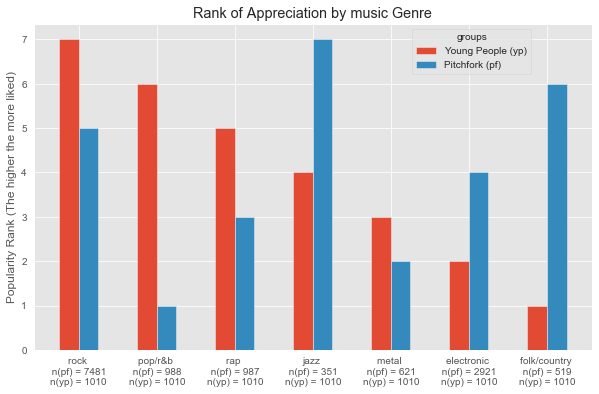

In [23]:
plt.style.use("ggplot")
fig = plt.figure(figsize = (10,6))
pos = np.asarray(list(range(7)))
plt.bar(pos - 0.125,agg["rank_yp"],width=0.25)
plt.bar(pos + 0.125,agg["rank_pf"], width=0.25)
plt.xticks(pos, [f"{genre} \n n(pf) = {agg.loc[genre,'count_pf']} \nn(yp) = {len(yp_music_df)}" for genre in agg.index])
plt.title("Rank of Appreciation by music Genre")
plt.ylabel("Popularity Rank (The higher the more liked)")
plt.legend(title = "groups", loc = "upper right", labels = ["Young People (yp)","Pitchfork (pf)"], bbox_to_anchor=(0.9,1))
plt.show()

### Man-Whitney Test

Man-Whitney test is used for ordinal data. We ask the question whether the observed rank differences could have happened by chance (H0).

In [24]:
yp_means = agg.mean_yp
pf_means = agg.mean_pf

In [25]:
stats.mannwhitneyu(yp_means,pf_means)

MannwhitneyuResult(statistic=4.0, pvalue=0.005301672691061329)

## Result

H0 can be rejected the Ranking of Pitchfork Users music preferences are different from the Young Students music Preferences

# Hypothesis # 2

## Analysing students that are an Only Child, and their happiness in life.


H_0 => students that are an only child are ***just as happy in life, if not more happy** than students that have siblings

> 𝐻_0 : The mean difference between treatment and control groups is zero. i.e. M(experiment) = M(control)

H_a => students that are an only child are less happy in life

> 𝐻_1: (1-tailed, <): The mean difference between experiment and control groups, is less than zero (negative).




In [26]:
# load data
students = pd.read_csv(f"{data_path}/responses.csv")
students.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


In [27]:
# create sample of 'Happiness in life' scores for students that are an Only Child (experiment)
# create sample of 'Happiness in life' scores for students that have siblings (control)
# keep both groups size the same

oc_happiness = students['Happiness in life'][students['Only child'] == 'yes'].dropna()
sibl_happiness = students['Happiness in life'][students['Only child'] == 'no'].dropna()

oc_happiness.describe()

count    252.000000
mean       3.670635
std        0.918302
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Happiness in life, dtype: float64

In [28]:
sibl_happiness.describe()

count    752.000000
mean       3.716755
std        0.791658
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Happiness in life, dtype: float64

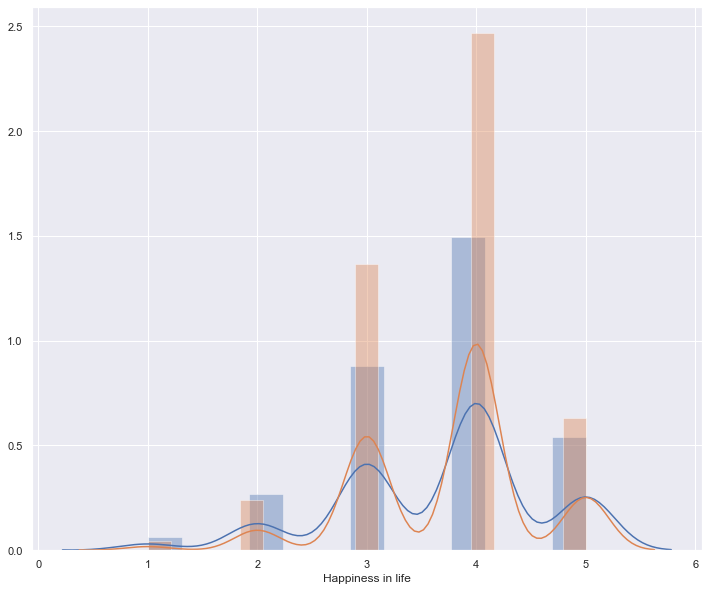

In [29]:
# plot the distribution of both samples

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})
sns.distplot(oc_happiness) # Blue distribution
sns.distplot(sibl_happiness) # Orange distribution

In [30]:
# Run a 2 sample ttest on your samples

'''
Calculates the T-test for the means of *two independent* samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples
have identical average (expected) values. This test assumes that the
populations have identical variances by default.

'''

stats.ttest_ind(oc_happiness, sibl_happiness, equal_var = False)

Ttest_indResult(statistic=-0.71337518290812, pvalue=0.47604734807129)

# Observations



## “being an only child has no effect on your happiness in life!”

After running a Two-Sample t-test on score results from students who are an only child (experiment group), and students with siblings (control group), we concluded that though the mean averages were not equal, their difference was not statistically significant, therefore we fail to reject the null hypothesis

# Hypothesis # 3: Music Genres vs. Movie Genres

At this point, we want to test the suggestion that students with similar taste in music also have similar taste in movies. We will focus on Metal & Hard Rock listeners and their affinity of Horror movies, and will use a **Chi-Squared Independence test** to see how Horror movie score correlates to Metal & Hard Rock score

Our Hypothesis statement is as follows:

> H_0 => There is **NO** statistically significant relationship between Metal & Hard Rock scores and Horror movie scores.

> H_a => There is a statistically significant relationship between Metal & Hard Rock scores and Horror movie scores.


In [31]:
# let's get some summary statistics on both scores
students[['Metal or Hardrock', 'Horror']].dropna().describe()

,Metal or Hardrock,Horror
count,1005.000000,1005.000000
mean,2.360199,2.789055
std,1.371163,1.409727
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,3.000000
75%,3.000000,4.000000
max,5.000000,5.000000


In [32]:
# create contigency table for Chi-Squared test

contingency_table = pd.crosstab(
    students['Metal or Hardrock'],
    students['Horror'],
    margins = True
)

contingency_table

Horror,1.0,2.0,3.0,4.0,5.0,All
Metal or Hardrock,,,,,,
1.0,106,85,82,54,56,383
2.0,52,41,47,45,34,219
3.0,36,35,35,33,25,164
4.0,36,22,26,26,26,136
5.0,26,15,23,20,19,103
All,256,198,213,178,160,1005


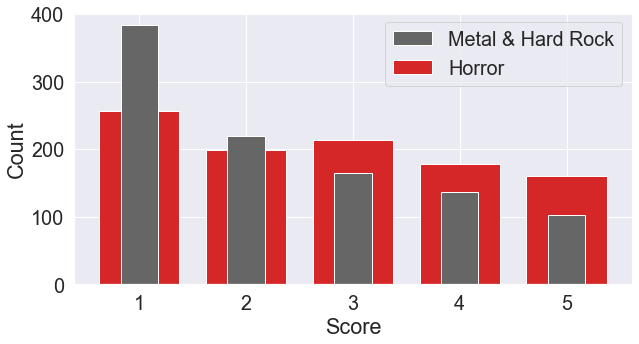

In [33]:
# visualize total of each score on both variables throughout the dataset

#assign the frequency of scores for plotting
metal = contingency_table.iloc[5,0:5].values
horror = contingency_table['All'][0:5]


#plot the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
scores = ["1","2","3","4","5"]
p1 = plt.bar(scores, metal, 0.75, color='#d62728')
p2 = plt.bar(scores, horror, 0.35, color='#666666')
plt.legend((p2[0], p1[0]), ('Metal & Hard Rock', 'Horror'))
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [34]:
# Run chi-squared test
stats.chi2_contingency(contingency_table)[:3] # X2, p-value, degrees of freedom

(12.4094776565072, 0.982950866929013, 25)

# Observations

With p score > .05 we fail to reject null hypothesis,

there is no correlation between scores on Metal or Hardrock and scores on Horror movies

# Hypothesis #4 Music Type vs. Educational level
## Data Preperation

In [35]:
#Select Music-Genres from Dataset
yp_edu_df = yp_df[[
#'Music',
 'Dance',
 'Folk',
'Country',
'Classical music',
'Musical',
 'Pop',
 'Rock',
 'Metal or Hardrock',
 'Punk',
 'Hiphop, Rap',
 'Reggae, Ska',
 'Swing, Jazz',
 'Rock n roll',
 'Alternative',
 'Latino',
 'Techno, Trance',
 'Opera',
 #'Folk, Country',
 'Education']]

In [36]:
yp_edu_df.Education.value_counts()

secondary school                    622
college/bachelor degree             212
masters degree                       81
primary school                       80
currently a primary school pupil     10
doctorate degree                      5
Name: Education, dtype: int64

#### Primary School Pupils and Doctorates will be dropped, because of low sample sizes

In [37]:
yp_edu_df["Education"] = yp_edu_df.Education.apply(lambda x: "3 MA" if x== 'masters degree' else "2 BA" if x == 'college/bachelor degree' else "1 Highschool" if x == 'secondary school' else '0 Primary' if x =="primary school" else x  );

/Users/pietrassyk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
#Split into Relevant Groups
PS_df = yp_edu_df.loc[yp_edu_df.Education == '0 Primary' ]
HS_df = yp_edu_df.loc[yp_edu_df.Education == '1 Highschool' ]
BA_df = yp_edu_df.loc[yp_edu_df.Education == '2 BA' ]
MA_df = yp_edu_df.loc[yp_edu_df.Education == '3 MA' ]

#Aggregate
PS_agg = PS_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)
HS_agg = HS_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)
BA_agg = BA_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)
MA_agg = MA_df.agg(["std","mean"]).transpose().sort_values("mean", ascending = False)


#Combine
yp_edu_df = pd.concat([PS_df,HS_df,BA_df,MA_df]) #TODO use split feature function instead

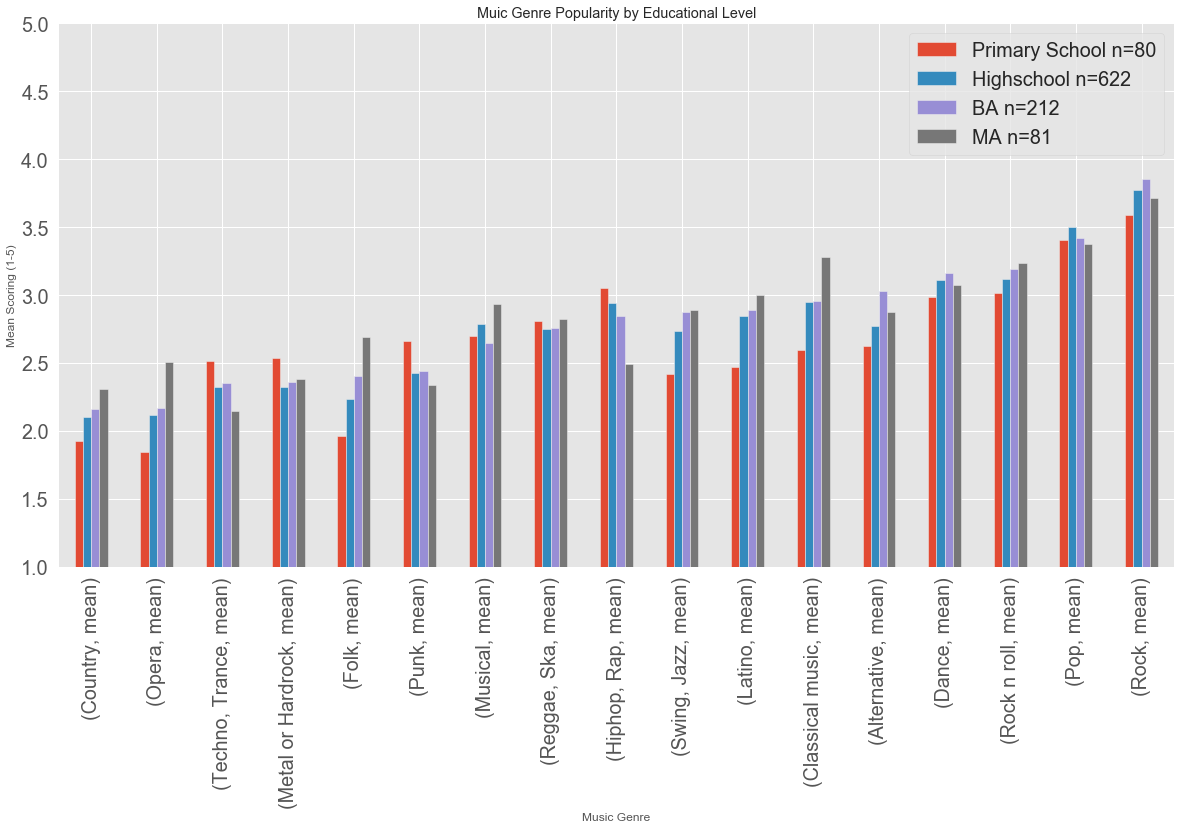

In [39]:
plt.style.use("ggplot")
plot_df = yp_edu_df.groupby("Education").agg(["mean"]).transpose().sort_values("2 BA")
plot_df.plot(kind = "bar", figsize = (20,10))
#plt.axhline(y = yp_edu_df.mean().mean(), ls = ":", label = "Avg Rating among Ratings")
plt.title("Muic Genre Popularity by Educational Level")
plt.ylabel("Mean Scoring (1-5)")
plt.ylim((1,5))
plt.xlabel("Music Genre")
plt.legend(labels = [f"Primary School n={len(PS_df)}",
                     f"Highschool n={len(HS_df)}",
                     f"BA n={len(BA_df)}" ,
                     f"MA n={len(MA_df)}" ]);

#TODO: Plot STD

## Hypothesis testing for Hypothesis #4

### MANOVA approach

A one way MANOVA was chosen, because the 17 target Variables(Music Genres) can be handled as numerical Data and there is only one predictor (Education) that can be handled categorically with 4 levels (PA,HS,BA,MA).

### Assumptions

#1 Obersvations are independant <br>
Study design description shows that Observations are independant 
see https://www.kaggle.com/miroslavsabo/young-people-survey for further information

In [40]:
#2 Dependant Variables are numerical
yp_edu_df.drop("Education" ,axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 11 to 1006
Data columns (total 17 columns):
Dance                995 non-null float64
Folk                 995 non-null float64
Country              995 non-null float64
Classical music      995 non-null float64
Musical              995 non-null float64
Pop                  995 non-null float64
Rock                 995 non-null float64
Metal or Hardrock    995 non-null float64
Punk                 995 non-null float64
Hiphop, Rap          995 non-null float64
Reggae, Ska          995 non-null float64
Swing, Jazz          995 non-null float64
Rock n roll          995 non-null float64
Alternative          995 non-null float64
Latino               995 non-null float64
Techno, Trance       995 non-null float64
Opera                995 non-null float64
dtypes: float64(17)
memory usage: 179.9 KB


In [41]:
#3 Independant Variable is Nomimanal

In [42]:
yp_edu_df.Education.dtype

dtype('O')

In [43]:
#4 Suffient Observations for each gruop in independant Variable (Education)
yp_edu_df.Education.value_counts()

1 Highschool    622
2 BA            212
3 MA             81
0 Primary        80
Name: Education, dtype: int64

In [44]:
#5 Linear Relationship between Dependant Variables
#sns.pairplot(yp_edu_df, hue = "Education", kind="reg" , plot_kwarg={"y_jitter": True, "x_jitter": True} )

In [45]:
#6 No Colinearity
#--> only a few correlations with a moderate value of r
yp_edu_df.drop("Education", axis = 1).corr().applymap(lambda x: x if abs(x)>0.5 else "")

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera
Dance,1,,,,,,,,,,,,,,,,
Folk,,1,,,,,,,,,,,,,,,
Country,,,1,,,,,,,,,,,,,,
Classical music,,,,1,,,,,,,,,,,,,0.593442
Musical,,,,,1,,,,,,,,,,,,
Pop,,,,,,1,,,,,,,,,,,
Rock,,,,,,,1,0.534862,0.513903,,,,,,,,
Metal or Hardrock,,,,,,,0.534862,1,0.54884,,,,,,,,
Punk,,,,,,,0.513903,0.54884,1,,,,,,,,
"Hiphop, Rap",,,,,,,,,,1,,,,,,,


In [46]:
#7 Homoscedasticity of dependant variables
# Check for Homoscedasticity using Levene
for key in PS_df.keys()[:-1]:
    p = stats.levene(PS_df[key],HS_df[key],BA_df[key],MA_df[key])[1]
    print(f"p-Value: {p} , homoscedastic ?: {p>0.05}")

p-Value: 0.09974210680822237 , homoscedastic ?: True
p-Value: 0.29603875945698094 , homoscedastic ?: True
p-Value: 0.45314985998025914 , homoscedastic ?: True
p-Value: 0.15506961632355526 , homoscedastic ?: True
p-Value: 0.4734187534673051 , homoscedastic ?: True
p-Value: 0.6144024516409419 , homoscedastic ?: True
p-Value: 0.9447639300231793 , homoscedastic ?: True
p-Value: 0.6335684321693873 , homoscedastic ?: True
p-Value: 0.2362105792716799 , homoscedastic ?: True
p-Value: 0.9846238756989542 , homoscedastic ?: True
p-Value: 0.8264828630011292 , homoscedastic ?: True
p-Value: 0.5301103355297841 , homoscedastic ?: True
p-Value: 0.266183087470772 , homoscedastic ?: True
p-Value: 0.8455941042675805 , homoscedastic ?: True
p-Value: 0.5247630643779688 , homoscedastic ?: True
p-Value: 0.8263899491252182 , homoscedastic ?: True
p-Value: 0.1649616360880656 , homoscedastic ?: True


All assumption seem to be valid to use for MANOVA

### Testing

In [47]:
#Building a linear model for MANOVA
yp_edu_manova_df = yp_edu_df
yp_edu_manova_df["Edu"] = yp_edu_manova_df.Education.apply(lambda x: 0 if x =="0 Primary" else 1 if x=="1 Highschool" else 3 if x == "3 MA" else 2)
yp_edu_manova_df = yp_edu_manova_df.drop("Education", axis = 1)

In [48]:
yp_edu_manova_df.head()

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Edu
11,1.0,1.0,1.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,2.0,0
49,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,0
64,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,0
65,3.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,0
97,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0


In [49]:
yp_edu_manova_df = yp_edu_manova_df.rename(lambda x: x.replace(",","").replace(" ","_").lower(), axis = "columns")

In [50]:
df = yp_edu_manova_df

In [51]:
#formula must contain dependant and independant Variables DV + DV... ~ IV ? <-- should work
DVs = df.columns[0:-1]
IVs = df.columns[-1]

formula = "+".join(DVs)+" ~ " + IVs
formula

'dance+folk+country+classical_music+musical+pop+rock+metal_or_hardrock+punk+hiphop_rap+reggae_ska+swing_jazz+rock_n_roll+alternative+latino+techno_trance+opera ~ edu'

In [52]:
mod = manova.MANOVA.from_formula(formula, data=df)
r = mod.mv_test()
print(r)

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value   Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.1057 17.0000 977.0000 486.4101 0.0000
         Pillai's trace 0.8943 17.0000 977.0000 486.4101 0.0000
 Hotelling-Lawley trace 8.4636 17.0000 977.0000 486.4101 0.0000
    Roy's greatest root 8.4636 17.0000 977.0000 486.4101 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
           edu           Value   Num DF  Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9554 17.0000 977.0000  2.6848 0.0002
          Pillai's trace 0.0446 17.0000 977.0000  2.6848 0.

### Result
p-values in the MANOVA Matrix show that there are significant differences in Musical Preference between different education levels.


### Post-Hoc Testing
In the following sections 1 way ANOVAs are used to determine Music Genres that significantly change with Education level.

In [53]:
yp_edu_df.head()

,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,Punk,"Hiphop, Rap","Reggae, Ska","Swing, Jazz",Rock n roll,Alternative,Latino,"Techno, Trance",Opera,Education,Edu
11,1.0,1.0,1.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,2.0,0 Primary,0
49,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,0 Primary,0
64,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,0 Primary,0
65,3.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,0 Primary,0
97,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0 Primary,0


In [54]:
#yp_edu_manova_df.edu = yp_edu_manova_df.edu.apply(lambda x: "PS" if x==0 else "HS" if x == 1 else "BA" if x ==2 else "MA")
yp_edu_manova_df.head()

,dance,folk,country,classical_music,musical,pop,rock,metal_or_hardrock,punk,hiphop_rap,reggae_ska,swing_jazz,rock_n_roll,alternative,latino,techno_trance,opera,edu
11,1.0,1.0,1.0,4.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,2.0,1.0,2.0,0
49,2.0,1.0,2.0,2.0,2.0,3.0,5.0,3.0,5.0,3.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,0
64,3.0,1.0,1.0,1.0,4.0,4.0,5.0,1.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0,2.0,2.0,0
65,3.0,1.0,2.0,2.0,1.0,3.0,3.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,4.0,2.0,0
97,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,0


In [55]:
df = yp_edu_manova_df
sig_ANOVAs = []
for genre in df.columns[:-1]:
    formula = f"{genre}~C(edu)"
    lm = ols(formula,df).fit()
    table = sm.stats.anova_lm(lm,typ = 2)
    reject_h0 = table[table.columns[-1]][0]<0.025
    if reject_h0:
        sig_ANOVAs.append(genre)
    print(genre)
    print(table)
    print(f"REJECT H0?: {reject_h0}")
    print("")

dance
               sum_sq     df        F    PR(>F)
C(edu)       1.957346    3.0  0.47759  0.697945
Residual  1353.832787  991.0      NaN       NaN
REJECT H0?: False

folk
               sum_sq     df         F    PR(>F)
C(edu)      26.271187    3.0  6.890771  0.000136
Residual  1259.401609  991.0       NaN       NaN
REJECT H0?: True

country
               sum_sq     df         F    PR(>F)
C(edu)       6.491940    3.0  1.889159  0.129702
Residual  1135.163169  991.0       NaN       NaN
REJECT H0?: False

classical_music
               sum_sq     df         F    PR(>F)
C(edu)      18.875205    3.0  4.067809  0.006935
Residual  1532.792966  991.0       NaN       NaN
REJECT H0?: True

musical
               sum_sq     df        F    PR(>F)
C(edu)       5.779747    3.0  1.20523  0.306657
Residual  1584.131633  991.0      NaN       NaN
REJECT H0?: False

pop
               sum_sq     df         F    PR(>F)
C(edu)       2.267282    3.0  0.556919  0.643581
Residual  1344.825471  991.0     

In [56]:
print(sig_ANOVAs)

['folk', 'classical_music', 'opera']


## Result: 
The differenes in Folk, Classical Music and Opera are significant at a 5% confidence level amongst different Educational Degrees